In [1]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")
        #self.last = nn.ConvTranspose2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, output_padding=1)
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))
        


In [2]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))




In [3]:
## 先前生成的样本的缓冲区
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):                       ## 放入一张图像，再从buffer里取一张出来
        to_return = []                                  ## 确保数据的随机性，判断真假图片的鉴别器识别率
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:          ## 最多放入50张，没满就一直添加
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:          ## 满了就1/2的概率从buffer里取，或者就用当前的输入图片
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

In [4]:
import torch.nn.functional as F

# define generator loss
def generator_loss(output, target):
    loss = F.mse_loss(output, target)
    return loss

# define discriminator loss
def discriminator_loss(output, target):
    loss = F.mse_loss(output, target)
    return loss

def identity_loss(real_output, gen_output):
    return F.l1_loss(real_output, gen_output)

def criterion_cycle_loss (real_output_A, real_output_B,gen_output_A,gen_output_B):
    cycle_loss_A=F.l1_loss(gen_output_A, real_output_A)
    cycle_loss_B=F.l1_loss(gen_output_B, real_output_B)
    cycle_loss = cycle_loss_A + cycle_loss_B
    return cycle_loss

# combine generator and discriminator loss
def gan_loss(gen_output, real_output, disc_output):
    gen_loss = generator_loss(gen_output, real_output)
    disc_loss = discriminator_loss(disc_output, torch.ones_like(disc_output))
    total_loss =  disc_loss
    return total_loss

In [5]:
from cyc_datasets import trainA_loader,trainB_loader,testA_loader,testB_loader
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G_A2B = Generator(img_channels=3, num_features=64, num_residuals=9).to(device)
G_B2A = Generator(img_channels=3, num_features=64, num_residuals=9).to(device)
D_A2B = Discriminator(in_channels=3, features=[64, 128, 256, 512]).to(device)
D_B2A = Discriminator(in_channels=3, features=[64, 128, 256, 512]).to(device)
# 定义超参数
batch_size = 1  # 批次大小
num_epochs = 75  # 训练轮数
lambda_identity = 5  # 身份损失函数的权重系数
lambda_cycle = 10  # 循环一致性损失函数的权重系数

#optimizers 
import torch.optim as optim
G_optimizer = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
# G_B2A_optimizer = optim.Adam(G_B2A.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_A2B_optimizer = optim.Adam(D_A2B.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_B2A_optimizer = optim.Adam(D_B2A.parameters(), lr=0.0002, betas=(0.5, 0.999))

fake_B_replay_buffer = ReplayBuffer(max_size=50)
fake_A_replay_buffer = ReplayBuffer(max_size=50)

In [6]:
from PIL import Image
import os
import numpy as np
import random
from torch.autograd import Variable
TOTAL_generator_loss = []
DISCRIMINATOR_loss = []
CYCLE_losses = []
IDEN_losses = []
saved_folder_path = "./outcome"

In [23]:

for epoch in range(num_epochs):
    for i, (real_A, real_B) in enumerate(zip(trainA_loader, trainB_loader)):
        Real_A=Variable(real_A[0].to(device))
        Real_B=Variable(real_B[0].to(device))

        # G_A2B_optimizer.zero_grad()
        # G_B2A_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        G_A2B.train()
        G_B2A.train()
        D_A2B.eval()
        D_B2A.eval()

        fake_B = G_A2B(Real_A)
        fake_A = G_B2A(Real_B) 
        recov_A = G_B2A(fake_B)
        recov_B = G_A2B(fake_A)
        
        real_pred_A = D_A2B(Real_A)
        real_pred_B = D_B2A(Real_B)
        fake_pred_A = D_A2B(fake_A)
        fake_pred_B = D_B2A(fake_B) 
        
        #cycle_loss
        cycle_loss = criterion_cycle_loss(Real_A, Real_B, recov_A, recov_B)
        
        # identity_loss
        iden_A = G_B2A(Real_A)
        iden_B = G_A2B(Real_B)
        iden_loss = identity_loss(Real_A, iden_A) + identity_loss(Real_B, iden_B)
        
        #gan_loss
        # gan_loss_A2B = gan_loss(fake_B, Real_A, D_A2B(fake_B))
        # gan_loss_B2A = gan_loss(fake_A, Real_B, D_B2A(fake_A))
        
        # t_r=Variable(torch.cuda.FloatTensor(1).fill_(1.0), requires_grad=False)
        gan_loss_A2B = generator_loss(fake_pred_B, Variable(torch.ones_like(real_pred_B, requires_grad=False)))
        gan_loss_B2A = generator_loss(fake_pred_A, Variable(torch.ones_like(real_pred_B,requires_grad=False)))

        #total_generator_loss
        Total_generator_loss=gan_loss_A2B + gan_loss_B2A + cycle_loss * lambda_cycle + iden_loss*lambda_identity
        

        # 反向传播和优化
        Total_generator_loss.backward()
        # G_A2B_optimizer.step()
        # G_B2A_optimizer.step()
        G_optimizer.step()
        
        #replay image
        fake_B = fake_B_replay_buffer.push_and_pop(fake_B)
        fake_A = fake_A_replay_buffer.push_and_pop(fake_A)        
        D_A2B_optimizer.zero_grad()
        D_B2A_optimizer.zero_grad()
        
        D_A2B.train()
        D_B2A.train()
        G_A2B.eval()
        G_B2A.eval()
        
        fake_pred_A = D_A2B(fake_A.detach())
        fake_pred_B = D_B2A(fake_B.detach()) 
        real_pred_A = D_A2B(Real_A)
        real_pred_B = D_B2A(Real_B)
        
        #discriminator_loss
        disc_loss_A =0.5* (discriminator_loss(real_pred_A, Variable(torch.ones_like(real_pred_A))) + discriminator_loss(fake_pred_A, Variable(torch.zeros_like(fake_pred_A))))
        disc_loss_A.backward()
        D_A2B_optimizer.step()
        
        disc_loss_B =0.5* (discriminator_loss(real_pred_B, Variable(torch.ones_like(real_pred_B))) + discriminator_loss(fake_pred_B, Variable(torch.zeros_like(fake_pred_B))))
        disc_loss_B.backward()
        D_B2A_optimizer.step()
        
        # Discriminator_loss = (disc_loss_A + disc_loss_B)*0.5
        
        # 反向传播和优化
        # Discriminator_loss.backward()
        # D_A2B_optimizer.step()
        # D_B2A_optimizer.step()
        

    TOTAL_generator_loss.append(Total_generator_loss.item())
    DISCRIMINATOR_loss.append(disc_loss_A.item()+disc_loss_B.item())
    CYCLE_losses.append(cycle_loss.item())
    IDEN_losses.append(iden_loss.item())    
    x = fake_A[0]
    x = x.detach().cpu().numpy()
    x = (x - x.min()) / (x.max() - x.min())
    x = np.transpose(x, (1, 2, 0))
    img = Image.fromarray((x * 255).astype(np.uint8))
    img.save(os.path.join(saved_folder_path, f"{epoch}.jpg"))
    
    # Save models checkpoints
    torch.save(G_A2B.state_dict(), 'output/netG_A2B2.pth')
    torch.save(G_B2A.state_dict(), 'output/netG_B2A2.pth')
    torch.save(D_A2B.state_dict(), 'output/netD_A2.pth')
    torch.save(D_B2A.state_dict(), 'output/netD_B2.pth')


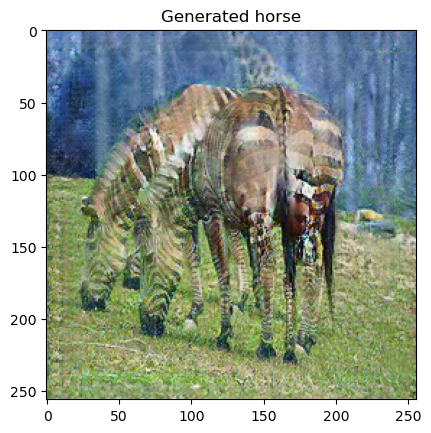

B_zebra---->A_horse


In [24]:
import matplotlib.pyplot as plt
import numpy as np
# x为torch.Tensor类型，其shape为[3, 256, 256]
x = fake_A[0]
# 将torch.Tensor类型转换成numpy数组类型，并将数值范围调整到[0, 1]
x = x.detach().cpu().numpy()
x = (x - x.min()) / (x.max() - x.min())
# 将numpy数组类型的图片展示出来
plt.imshow(np.transpose(x, (1, 2, 0)))
plt.title('Generated horse')
plt.show()
print('B_zebra---->A_horse')

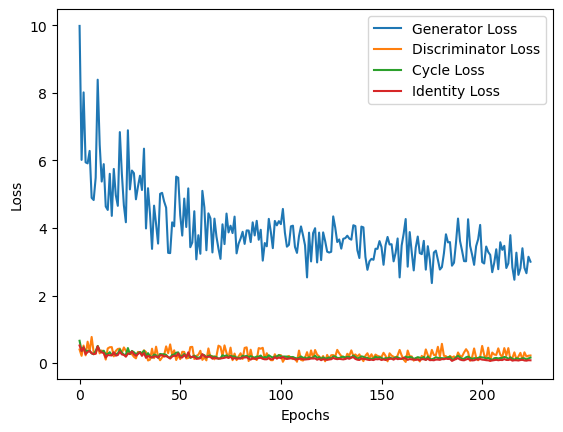

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(TOTAL_generator_loss, label="Generator Loss")
plt.plot(DISCRIMINATOR_loss, label="Discriminator Loss")
plt.plot(CYCLE_losses, label="Cycle Loss")
plt.plot(IDEN_losses, label="Identity Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


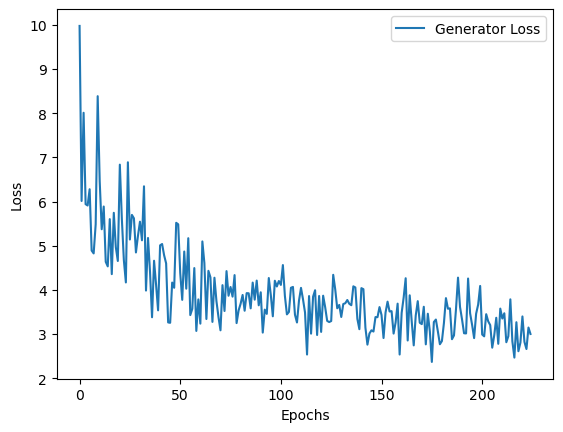

In [26]:
plt.figure()
plt.plot(TOTAL_generator_loss, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

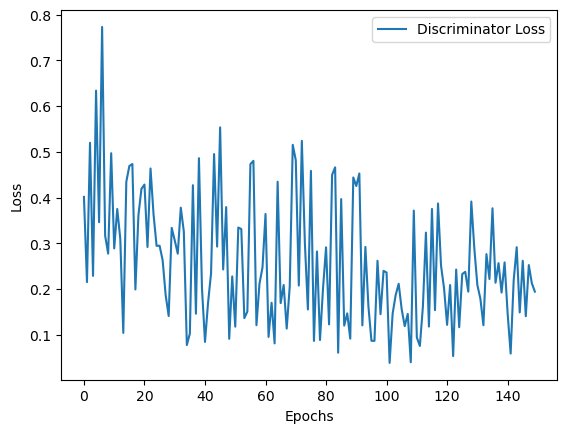

In [20]:
plt.figure()
plt.plot(DISCRIMINATOR_loss, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

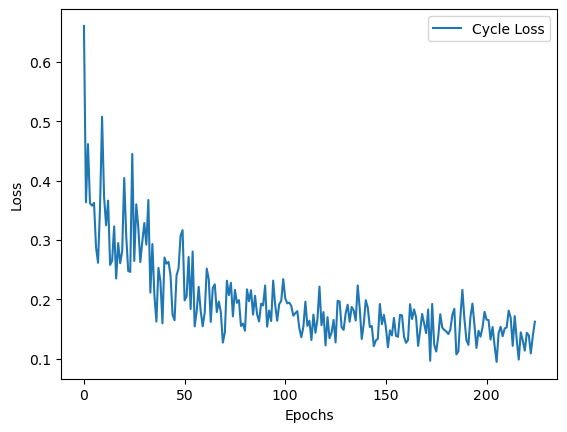

In [27]:
plt.figure()
plt.plot(CYCLE_losses, label="Cycle Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

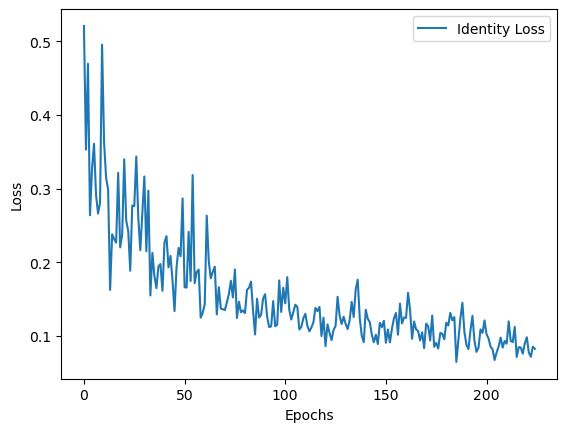

In [28]:
plt.figure()
plt.plot(IDEN_losses, label="Identity Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
!nvidia-smi


In [ ]:
!kill 111133      